In [1]:
from utils_project import *

# reverse the sign of power_tendency_mean in data
data['power_mean_mean']     = data['power_mean_mean'] * -1
data['power_centroid_mean'] = data['power_centroid_mean'] * -1
for role in character_roles[:5]:
    data[f'power_mean_{role}'] = data[f'power_mean_{role}'] * -1
    data[f'power_centroid_{role}'] = data[f'power_centroid_{role}'] * -1
sample_dict = update_sample_dict(data)
# data[['sub_id', 'sample', 'affil_mean_mean', 'power_mean_mean'] + demo_controls + [f'factor_{f}_quartimax_thresh25' for f in ['social', 'mood', 'compulsive']]].to_excel('data.xlsx')

Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


# Test main predictions: social specificity + contribution of both dimensions

Factor scores ~ mean affil + mean power + controls
- factor loadings: weights defining relationship between item & factor 
- factor scores: each individual's score on each factor, ie the linear combination of factor loadings and items 


,sample,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
1,Initial,factor_social_quartimax_thresh25,affil_mean_mean,555.0,0.055,1739.47,1634.80,-0.2255,0.0426,-0.3092,-0.1418,-5.2914,0.0000,0.0000,1.0000
2,Initial,factor_social_quartimax_thresh25,power_mean_mean,555.0,0.055,1739.47,1634.80,-0.1352,0.0429,-0.2196,-0.0509,-3.1491,0.0017,0.0009,0.9991
1,Initial,factor_mood_quartimax_thresh25,affil_mean_mean,555.0,0.072,1729.26,1624.59,-0.1077,0.0422,-0.1907,-0.0247,-2.5496,0.0111,0.0055,0.9945
2,Initial,factor_mood_quartimax_thresh25,power_mean_mean,555.0,0.072,1729.26,1624.59,-0.0117,0.0426,-0.0953,0.0719,-0.2754,0.7831,0.3916,0.6084
1,Initial,factor_compulsive_quartimax_thresh25,affil_mean_mean,555.0,0.018,1761.60,1656.93,0.0802,0.0434,-0.0051,0.1655,1.8466,0.0653,0.9673,0.0327
2,Initial,factor_compulsive_quartimax_thresh25,power_mean_mean,555.0,0.018,1761.60,1656.93,0.0254,0.0438,-0.0606,0.1113,0.5796,0.5624,0.7188,0.2812
1,Validation,factor_social_quartimax_thresh25,affil_mean_mean,231.0,0.051,819.01,734.02,-0.2445,0.0649,-0.3725,-0.1166,-3.7658,0.0002,0.0001,0.9999
2,Validation,factor_social_quartimax_thresh25,power_mean_mean,231.0,0.051,819.01,734.02,-0.1142,0.0660,-0.2442,0.0158,-1.7306,0.0849,0.0424,0.9576
1,Validation,factor_mood_quartimax_thresh25,affil_mean_mean,231.0,0.022,826.70,741.71,-0.1384,0.0659,-0.2683,-0.0085,-2.0991,0.0369,0.0184,0.9816
2,Validation,factor_mood_quartimax_thresh25,power_mean_mean,231.0,0.022,826.70,741.71,-0.0196,0.0670,-0.1516,0.1123,-0.2931,0.7697,0.3849,0.6151


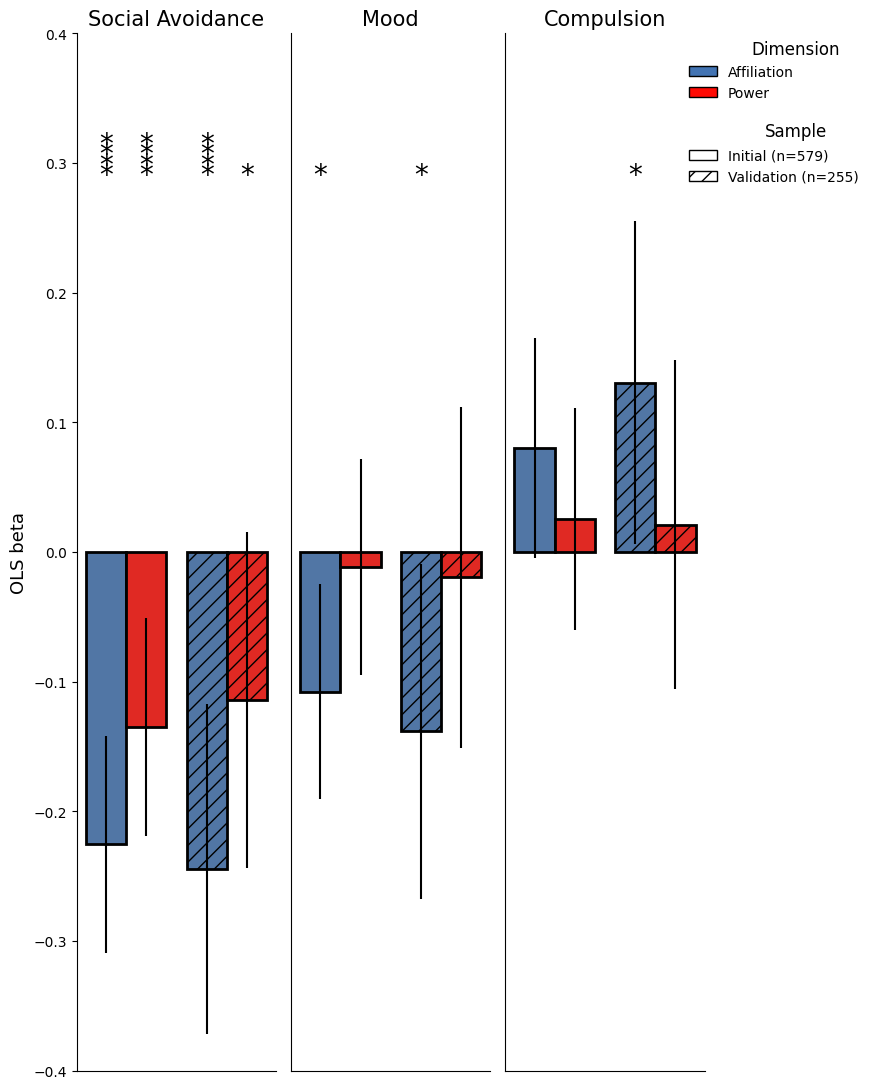

In [8]:
#------------------------------------------------------------------------------------------------------------
# run OLS
#------------------------------------------------------------------------------------------------------------

pd.set_option('display.precision', 4)
samples    = samples[:2]
models     = [['affil_mean_mean', 'power_mean_mean']] # [['affil_centroid_mean', 'power_centroid_mean']] # 
task_preds = flatten_lists(models)
factors    = [f'factor_{f}_quartimax_thresh25' for f in ['social', 'mood', 'compulsive']]

res = []
for sample in samples:
    df = sample_dict[sample]['data']
    for factor, preds in itertools.product(factors, models):
        ols_df = run_ols(X=preds, y=factor, data=df, covariates=all_controls)[0]
        ols_df.insert(0, 'sample', sample)
        ols_df.insert(1, 'factor', factor)
        res.append(ols_df[ols_df['x'].isin(preds)])
ols_df = pd.concat(res)


#------------------------------------------------------------------------------------------------------------
# plot OLS betas, cis & significance
#------------------------------------------------------------------------------------------------------------

# assign labels & colors
plot_df = ols_df[ols_df['x'].isin(task_preds)]
legend_labels, plot_colors = [], []
for pred in task_preds:
    legend_labels.append(behav_labels[pred][0])
    plot_colors.append(behav_labels[pred][1])
pal = sns.set_palette(sns.color_palette(plot_colors))
titles = ['Social Avoidance', 'Mood', 'Compulsion']
sample_hatches = ['', '//', 'O']

fig, axs = create_subplots((6, 6),
                          {(0,0): (6, 2),
                           (0,2): (6, 2), 
                           (0,4): (6, 2)},
                        figsize=(9, 11), annotate=False)
reg_axs = [axs[0], axs[1], axs[2]]
# add_subfig_letter(reg_axs[0], 'A', x=-.2, y=1.10, fontsize=20)

for i, (factor, ax) in enumerate(zip(factors, reg_axs)):
    
    plot_social = plot_df[plot_df['factor'] == factor]
    ax = plot_barplot(x='sample', y='beta', hue="x", data=plot_social, ax=ax, color=pal, linewidth=2)
    ax.set_title(titles[i], fontsize=title_fontsize)
    ax.set_ylim(-.4, .4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('')

    if i == 0:
        ax.set_ylabel('OLS beta', fontsize=label_fontsize)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])

    task_preds_ = np.repeat(task_preds, len(samples))
    for b, bar in enumerate(ax.patches): # for diff bars in each panel

        sample = samples[b % len(samples)]

        # get OLS results
        ols_res = ols_df[(ols_df['factor'] == factor) & 
                         (ols_df['x'] == task_preds_[b]) & 
                         (ols_df['sample'] == sample)]
        beta, pval, se = ols_res[['beta', 'p', 'se']].values.astype(float)[0]
        ci = se * 1.96

        # directional hypotheses for social factor
        if 'social' in factor:
            if ('affil' in task_preds_[b] and beta < 0 or 'power' in task_preds_[b] and beta < 0):
                pval = pval / 2
        
        # bar styles for diff samples
        bar.set_hatch(sample_hatches[b % len(samples)])

        # add the CI bars & significance stars
        bar_x = bar.xy[0] + bar.get_width()/2  # where on x-axis is bar center
        # ax.text(bar_x, .3, b, ha='center', va='bottom', color='black', size=10) # label with b, if needed for debgging
        ax.errorbar(bar_x, beta, yerr=ci, 
                    ecolor='black', fmt=' ', 
                    zorder=2, elinewidth=1.5, 
                    dash_capstyle='butt')
        pthreshs = [0.05, 0.01, 0.005, 0.001] 
        for ti, thr in enumerate(pthreshs):
            if pval < thr:
                ax.text(bar_x, .28+(ti*.008), '*', ha='center', va='bottom', color='black', size=20)

# legend
handles = [mpatches.Patch(facecolor=plot_colors[s], edgecolor='black', 
                          hatch=sample_hatches[0], label=dim) for s, dim in enumerate(['Affiliation', 'Power'])]
handles.extend([mpatches.Patch(facecolor='white', edgecolor=None, label=None)]) # blank space
handles.extend([mpatches.Patch(facecolor='white', edgecolor=None, label=None)]) # blank space
sample_labels = []
for s, sample in enumerate(samples):
    n = len(sample_dict[sample]['data'])
    sample_labels.append(f'{sample} (n={n})')
    handles.extend([mpatches.Patch(facecolor='white', edgecolor='black', hatch=sample_hatches[s], label=f'{sample} n={n}')])
reg_axs[2].legend(title='', loc='upper right', handles=handles, labels=legend_labels + ['', ''] + sample_labels,
                    title_fontsize=legend_label_fontsize, fontsize=10, frameon=False, 
                    bbox_to_anchor=(1.8, .975), borderaxespad=0)

plt.figtext(.89, .95, 'Dimension', ha='center', va='center', fontsize=legend_title_fontsize)
plt.figtext(.89, .875, 'Sample', ha='center', va='center', fontsize=legend_title_fontsize)
plt.tight_layout()
save_figure(fig, f'{fig_dir}/Fig4_factor-regression')

del ols_df['X']
del ols_df['factor']
display(ols_df.round(4))

# plot correlaitons
# corr_axs    = [axs[3], axs[4]]
# corr_vars   = ['affil_mean_mean', 'power_mean_mean']
# corr_titles = ['Affiliation', 'Power']
# add_subfig_letter(corr_axs[0], 'B', x=-.2, y=1.10, fontsize=20)
# for s, sample in enumerate(samples):
#     df = sample_dict[sample]['data']
#     for i, pred in enumerate(corr_vars):
#         ax = corr_axs[i]
#         ax = plot_regplot(x=df[pred], y=df[factors[0]], ax=ax, color=behav_labels[pred][1])
#         ax.set_title(corr_titles[i], fontsize=title_fontsize)
#         ax.set_ylabel('', fontsize=12)
#         if 'affil' in pred:      xlabel = 'Affiliation (z)'
#         elif 'power' in pred:    xlabel = 'Power (z)'
#         elif 'dist' in pred:     xlabel = 'Distance (z)'
#         if s == 1: ax.set_xlabel(xlabel, fontsize=12)
#         else:      ax.set_xlabel('', fontsize=12)
#         if i == 0: ax.set_ylabel('Social Avoidance score', fontsize=label_fontsize)
#         else:      ax.set_ylabel('')

## Summary of independent & covariate models
    
    Independent: Factor ~ Intercept + Behavior + error
    Covariate: Behavior ~ Intercept + Factors + error

In [9]:
results = []
beh_vars = ['affil_mean_mean', 'power_mean_mean'] # , 'pov_2d_dist_mean_mean', 'pov_2d_angle_mean_mean_cos']
for sample in ['Initial', 'Validation']: # 
    m = 0

    df = sample_dict[sample]['data']
    if sample != 'Combined':
        controls = all_controls
    else:
        controls = all_controls + ['sample']

    # # factor ~ behaviors, for each factor
    # for factor in factors:
    #     m += 1
    #     ols_df = run_ols(X=beh_vars, y=factor, data=df, covariates=controls)[0]
    #     ols_df.insert(1, 'sample', sample)
    #     ols_df.insert(2, 'model_num', m)
    #     results.append(ols_df[ols_df['x'].isin(beh_vars)])

    # # behavior ~ factors, for each behavior
    # for beh_var in beh_vars:
    #     m += 1
    #     ols_df = run_ols(X=factors, y=beh_var, data=df, covariates=controls)[0]
    #     ols_df.insert(1, 'sample', sample)
    #     ols_df.insert(2, 'model_num', m)
    #     results.append(ols_df[ols_df['x'].isin(factors)])

    # behavior ~ factor, for each behavior and factor
    for beh_var in beh_vars:
        for factor in factors:
            m += 1
            ols_df = run_ols(X=factor, y=beh_var, data=df, covariates=controls)[0]
            ols_df.insert(1, 'sample', sample)
            ols_df.insert(2, 'model_num', m)
            results.append(ols_df[ols_df['x'].isin([factor])])

# clean up and display
ols_df = pd.concat(results).reset_index(drop=True).iloc[:,1:]
ols_df['y'] = ols_df['y'].apply(lambda x: ('_').join(x.split('_')[0:2]))
ols_df['x'] = ols_df['x'].apply(lambda x: ('_').join(x.split('_')[0:2]))
for col in ['aic', 'se', 'p_right']: 
    del ols_df[col]
ols_df = ols_df.sort_values(['sample', 'model_num', 'x', 'y']).reset_index(drop=True)
display(ols_df.round(3))


,sample,model_num,y,x,dof,adj_rsq,bic,beta,95%_lb,95%_ub,t,p,p_left
0,Initial,1,affil_mean,factor_social,556.0,0.088,1713.68,-0.198,-0.278,-0.118,-4.892,0.000,0.000
1,Initial,2,affil_mean,factor_mood,556.0,0.060,1731.41,-0.108,-0.191,-0.024,-2.537,0.011,0.006
2,Initial,3,affil_mean,factor_compulsive,556.0,0.054,1734.76,0.074,-0.007,0.156,1.789,0.074,0.963
3,Initial,4,power_mean,factor_social,556.0,0.073,1723.07,-0.099,-0.180,-0.019,-2.438,0.015,0.008
4,Initial,5,power_mean,factor_mood,556.0,0.063,1729.23,0.002,-0.081,0.085,0.049,0.961,0.520
5,Initial,6,power_mean,factor_compulsive,556.0,0.063,1729.10,0.014,-0.067,0.096,0.347,0.729,0.636
6,Validation,1,affil_mean,factor_social,232.0,0.080,806.64,-0.229,-0.352,-0.106,-3.660,0.000,0.000
7,Validation,2,affil_mean,factor_mood,232.0,0.045,816.20,-0.135,-0.262,-0.008,-2.090,0.038,0.019
8,Validation,3,affil_mean,factor_compulsive,232.0,0.044,816.41,0.137,0.005,0.268,2.044,0.042,0.979
9,Validation,4,power_mean,factor_social,232.0,0.067,810.46,-0.094,-0.218,0.031,-1.484,0.139,0.070


## All characters show the effect
Most consistent character is Assistant; most consistent dimension across characters is affiliation

In [ ]:
samples_ = ['Combined']

ols_res = []
for sample in samples_:
    for factor, role in itertools.product(factors[:1], character_roles[:5]):
        preds = [f'affil_mean_{role}', f'power_mean_{role}']
        df = sample_dict[sample]['data']
        ols_df = run_ols(X=preds, y=factor, data=df, covariates=all_controls[:5])[0]
        ols_df.insert(0, 'sample', sample)
        ols_df.insert(1, 'character', role)
        ols_res.append(ols_df[ols_df['x'].isin(preds)])
ols_df = pd.concat(ols_res).reset_index(drop=True)
ols_df['x'] = ols_df['x'].apply(lambda x: x.split('_')[0].capitalize())
print_df(ols_df)

# plot
for sample in samples_:
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    fig.suptitle(sample, fontsize=title_fontsize)
    sns.barplot(x='character', y='beta', hue='x', data=ols_df[ols_df['sample'] == sample], 
                edgecolor='black', linewidth=1, errcolor='black', errwidth=1,
                ax=ax, dodge=True)
    ax.set_ylabel('Beta', fontsize=label_fontsize)
    ax.set_xlabel('Character', fontsize=label_fontsize)
    ax.legend_.remove()
    plt.show()
# fig, ax = plt.subplots(1, 1, figsize=(5,4))
# fig.suptitle('By character', fontsize=title_fontsize)
# sns.barplot(x='character', y='beta', hue='x', data=ols_df, 
#             edgecolor='black', linewidth=1, errcolor='black', errwidth=1,
#             ax=ax, dodge=True)
# ax.set_ylabel('Beta', fontsize=label_fontsize)
# ax.set_xlabel('Character', fontsize=label_fontsize)
# ax.legend_.remove()
# plt.show()

## Likability and impact

In [ ]:
data_ = sample_dict['Validation']['data']
print(data_.shape)
display(run_ols(X=['likability_mean', 'impact_diff_mean'], y='factor_social_quartimax_thresh25', 
        data=df, covariates=all_controls)[0].iloc[1:3,2:])
display(run_ols(X=['likability_mean', 'impact_diff_mean'], y='pov_2d_dist_mean', 
        data=df, covariates=all_controls)[0].iloc[1:3,2:])

## Are there more affiliation-related and power-related items?

In [ ]:
factor_loadings = pd.read_excel(glob.glob(f'{base_dir}/factor_analyses/factor_loadings_*')[0])
factor_loadings = factor_loadings.sort_values('Social Avoidance', ascending=False)


#----------------------------------------------------------
# top N items that load most heavily
#----------------------------------------------------------


n_top = 25
top_items = list(factor_loadings['item'][:n_top].values)
assert len(np.unique(top_items)) == n_top

df = data[['affil_mean_mean', 'power_mean_mean'] + top_items]
ols_res, ols_individ_res = [], []
for yvar in ['affil_mean_mean', 'power_mean_mean']:
    ols_df = run_ols(X=top_items, y=yvar, data=df)[0]
    ols_res.append(ols_df[ols_df['x'].isin(top_items)])
    for item in top_items:
        ols_df = run_ols(X=item, y=yvar, data=df)[0]
        ols_individ_res.append(ols_df[ols_df['x'].isin([item])])

ols_res = pd.concat(ols_res)
ols_res = ols_res.sort_values('p', ascending=True).reset_index(drop=True)
ols_items = ols_res[['x', 'y', 'beta']]
ols_items.columns = ['item', 'dimension', 'beta']
ols_items = ols_items.merge(questionnaire_items[['item', 'text']])

ols_individ_res = pd.concat(ols_individ_res)
ols_individ_res = ols_individ_res.sort_values('p', ascending=True).reset_index(drop=True)
ols_individ_items = ols_individ_res[['x', 'y', 'beta']]
ols_individ_items.columns = ['item', 'dimension', 'beta']
ols_individ_items = ols_individ_items.merge(questionnaire_items[['item', 'text']])


#----------------------------------------------------------
# plot correlations
#----------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(20, 8))
ax = axs[0]
sns.barplot(x='x', y='beta', hue='y', hue_order=['affil_mean_mean', 'power_mean_mean'], data=ols_res, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax = axs[1]
sns.barplot(x='x', y='beta', hue='y', hue_order=['affil_mean_mean', 'power_mean_mean'], data=ols_individ_res, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

# Comparing reference frames for Polar coordinates
- diff sample sizes for diff sets of variables: cannot compare b/c the larger the sample, the smaller the likelihood and the larger the IC
    - so the solution would have to be to subset the sample so that the variable w/ smallest n defines the rest...

In [ ]:
cartesian_models = [['affil_mean_mean', 'power_mean_mean']]
polar_models = [['pov_2d_dist_mean_mean', 'pov_2d_angle_mean_mean_cos'], 
                ['neu_2d_dist_mean_mean', 'neu_2d_angle_mean_mean_cos']] # doesnt make a difference whether include sine, i think location is fully determiend by distance & cosine angle
other_models = [['area'],['volume'],['consistency_mean'], ['Q4_overlap', 'Q2_overlap'], ['affil_centroid_mean_z'], ['power_centroid_mean_z'],]

models = polar_models
preds  = np.unique(flatten_lists(models))
res = []
for model in models:
    ols_df = run_replicated_ols(model, social_factor, controls=all_controls, alpha=None, filter_repl=False)
    ols_df['model'] = ' + '.join(model)
    res.append(ols_df)
mc_df = pd.concat(res).reset_index(drop=True)
display(mc_df[['sample', 'model', 'x', 'beta', '95%_lb' ,'95%_ub', 't', 'p_right', 'bic']])

# order results by BIC
metric = 'bic'
results = []
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for s, sample in enumerate(samples[:2]):
    results_ = mc_df[mc_df['sample'] == sample]
    results_.drop_duplicates(subset=['model'], inplace=True)
    results_.sort_values(metric, ascending=True, inplace=True)
    display(results_)
    results.append(results_)

    ax = axs[s]
    sns.barplot(x='model', y=metric, data=results_, ax=ax, 
                ci=None, palette='Blues_d', edgecolor="black")
    ax.set_title(sample, fontsize=title_fontsize)
    ax.set_ylabel(metric, fontsize=label_fontsize)
    ax.set_ylim(np.min(results_[metric]) - np.min(results_[metric]) * .0005, 
                np.max(results_[metric]) + np.max(results_[metric]) * .0005)
    ax.set_xticklabels(results_['model'].values.tolist(), rotation=60, ha='right')
    ax.set_xlabel('')
plt.tight_layout()

#### power analysis stuff

In [ ]:
data_ = sample_dict['Initial']['data']

# calculate the r between social distance and social avoidance in validation sample
r, p = scipy.stats.pearsonr(data_['pov_2d_dist_mean_mean'], data_['factor_social_quartimax_thresh25'])
print(f'Pearson r = {r:.4f}, p = {p:.3f}')

# # calculate the partial r2 for social avoidance regression
# formula = 'factor_social_quartimax_thresh25 ~ pov_2d_dist_mean_mean + ' + ' + '.join(all_controls)
# partial_r2, n_predictors = compute_r2_partial(formula, data_, 'pov_2d_dist_mean_mean')
# print(f"Partial R^2 for pov_2d_dist_mean_mean: {partial_r2:.4f}")
# print(f"Number of predictors in the model: {n_predictors}")

### Understanding the effects of the variables
- Affil & power drive distance (affil > power)
- Power drives angle (~no affil effect)
    - abslute value reflects the power differential 

obviously this should be the case w/in people: but it could be that *across* people one is more important than the other

indeed, affiliation is more important

In [ ]:
data['power_mean_mean_abs'] = np.abs(data['power_mean_mean'])
display(run_ols(X=['affil_mean_mean', 'power_mean_mean_abs'], y='pov_2d_dist_mean_mean', data=data, covariates=demo_controls)[1].summary())
display(run_ols(X=['affil_mean_mean', 'power_mean_mean_abs'], y='pov_2d_angle_mean_mean_cos', data=data, covariates=demo_controls)[1].summary())

# Social quadrant occupancy

In [ ]:
C = data[['Q1_overlap', 'Q2_overlap', 'Q3_overlap', 'Q4_overlap', social_factor, mood_factor, compulsive_factor]].corr()
sns.heatmap(C)
plt.show()

#-----------------------------------------------------------------------------------------------
# plot the quadrants by diff. levels of social factor
#-----------------------------------------------------------------------------------------------

q_names = ['Q1_overlap', 'Q2_overlap', 'Q3_overlap', 'Q4_overlap']
factor_splits = ['lowest', 'low', 'medium', 'high', 'highest'] # split into 5 groups
data[f'{social_factor}_split'] = pd.qcut(data[social_factor], len(factor_splits), labels=factor_splits)
ratings_quadrant_melted = pd.melt(data, id_vars=[f'{social_factor}_split'], value_vars=q_names)

fig, axs = plt.subplots(1, 1+len(q_names), figsize=(4.5*(1+len(q_names)), 4), gridspec_kw={'width_ratios': [2] + [1]*len(q_names)})
sns.barplot(ax=axs[0], x=f'{social_factor}_split', y='value', hue='variable', 
            data=ratings_quadrant_melted, 
            edgecolor='black', alpha=0.5)
for q, q_name in enumerate(q_names):
    sns.barplot(ax=axs[q+1], x=f'{social_factor}_split', y=q_name, 
                data=data, 
                palette='Blues', edgecolor='black', alpha=0.5)
    axs[q+1].set_ylabel(f'Q{q+1} %')

axs[0].set_ylabel('Overlap %')
for ax in axs:
    ax.set_title(' ')
    ax.tick_params(axis='x', labelsize='small')
    ax.set_xlabel('Social Avoidance Level')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles=handles, labels=['Q1', 'Q2', 'Q3', 'Q4'],
              loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), fontsize='small',
              ncol=4, mode="expand", borderaxespad=0)
plt.tight_layout()

#-----------------------------------------------------------------------------------------------
# plot the quadrants correlations
#-----------------------------------------------------------------------------------------------

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for i, quadrant in enumerate(['Q2_overlap', 'Q1_overlap', 'Q3_overlap', 'Q4_overlap']):
    for s, sample in enumerate(samples[:2]):
        df = sample_dict[sample]['data']
        sns.regplot(x=quadrant, y=social_factor, data=df, 
                    ax=axs[i//2, i%2], color=sample_colors[s], 
                    scatter_kws={'alpha':.5, 's':20})
        # add_sig_stars(quadrant, social_factor, df, demo_controls, 
        #               ax=axs[i//2, i%2], color=sample_colors[s])
    axs[i//2, i%2].set_xlabel(quadrant)
    if i%2 == 0: axs[i//2, i%2].set_ylabel('Social Avoidance')
    else:        axs[i//2, i%2].set_ylabel('')
plt.tight_layout()


In [ ]:
def calc_relative_quad_pref(df, means=None):
    # assign rows values depending on which quadrant they have largest value in 
    df['Q'] = np.argmax(df[['Q1_overlap', 'Q2_overlap', 'Q3_overlap', 'Q4_overlap']].values, axis=1) + 1

    # subtract mean to get the more than expected overlap in each quadrant
    quad_means = []
    for quad in range(1, 5):
        if means is None:
            df[f'Q{quad}_adj'] = df[f'Q{quad}_overlap'] - np.mean(df[f'Q{quad}_overlap'])
            quad_means.append(np.mean(df[f'Q{quad}_overlap']))
        else:
            df[f'Q{quad}_adj'] = df[f'Q{quad}_overlap'] - means[quad-1]
            quad_means.append(means[quad-1])

    # assign rows values depending on which quadrant they have largest value in
    df['Q_adj'] = np.argmax(df[['Q1_adj', 'Q2_adj', 'Q3_adj', 'Q4_adj']].values, axis=1) + 1

    # relabel quadrants
    relabel = {1: 'High Affil & Low Power', 
               2: 'Low Affil & Low Power', 
               3: 'Low Affil & High Power', 
               4: 'High Affil & High Power'}
    df['Q_adj_numeric'] = df['Q_adj']
    df['Q_adj_label']   = df['Q_adj'].map(relabel)
    return df, quad_means

dfs = []

# get the means from initial
df, quad_means = calc_relative_quad_pref(sample_dict['Initial']['data'])
dfs.append(df)

# use the mean from initial sample
df, _ = calc_relative_quad_pref(sample_dict['Validation']['data'], means=quad_means) 
dfs.append(df)

data = pd.concat(dfs).reset_index(drop=True)
data['pov_2d_dist_mean_mean_z'] = scipy.stats.zscore(data['pov_2d_dist_mean_mean'])
data['pov_2d_angle_mean_mean_cos_z'] = scipy.stats.zscore(data['pov_2d_angle_mean_mean_cos'])
sample_dict = update_sample_dict(data)

print('Fractions in each quadrant')
for q in range(1,5):
    for sample in samples:
        # print % of subjects in that q for each sample
        n = len(sample_dict[sample]['data'])
        print(f'{sample}: Q{q} = {np.sum(sample_dict[sample]["data"][f"Q_adj"] == q) / n:.3f}')

In [ ]:
def run_ttest_ind(g1, g2, alternative='two-sided'):
    # need to run this an ancova...
    g1 = g1[np.isfinite(g1)]
    g2 = g2[np.isfinite(g2)]
    g1_n, g2_n = len(g1), len(g2)
    g1_m, g1_sd = np.mean(g1), np.std(g1)
    g2_m, g2_sd = np.mean(g2), np.std(g2)
    t, p = scipy.stats.ttest_ind(g1, g2, equal_var=False, alternative=alternative)
    dof = len(g1) + len(g2) - 2
    return t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]]

q1_mask = data['Q_adj'] == 1 # 'Affil.\nSubmissive'
q2_mask = data['Q_adj'] == 2 # 'Unaffil.\nSubmissive'
q3_mask = data['Q_adj'] == 3 # 'Unaffil.\nDominant'
q4_mask = data['Q_adj'] == 4 # 'Affil.\nDominant'

quad_df = pd.DataFrame(columns=['g1', 'g2', # groups
                                'sample', 
                                'n1', 'n2', # number of subjects in the 2 groups
                                'comp', 
                                'm1', 'm2', 
                                'sd1', 'sd2', 
                                'dof', 't', 'p'])
combos  = list(itertools.combinations(range(1, 5), 2))
comps   = [social_factor]
for s, sample in enumerate(samples[:2]):
    data_ = data[data['sample'] == s]
    for combo in combos:
        g1_data = data_[data_['Q_adj'] == combo[0]]
        g2_data = data_[data_['Q_adj'] == combo[1]]

        t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(g1_data.loc[:, social_factor], g2_data.loc[:, social_factor])

        quad_df.loc[len(quad_df)] = [f'{combo[0]+1} : {combo[0]}', f'{combo[1]+1} : {combo[1]}', 
                                    sample, g1_n, g2_n, 
                                    social_factor, g1_m, g2_m, g1_sd, g2_sd, dof, t, p]
display(quad_df)

In [ ]:
ha = ['Affil.\nSubmissive', 'Affil.\nDominant']
la = ['Unaffil.\nSubmissive', 'Unaffil.\nDominant']
hd = ['Affil.\nDominant', 'Unaffil.\nDominant']
ld = ['Affil.\nSubmissive', 'Unaffil.\nSubmissive']

# Initial sample: 
data_ = data[data['sample'] == 'Initial']

# high v. low affiliation
ha_data = data_.loc[data_['Q_adj_label'].isin(ha), social_factor]
la_data = data_.loc[data_['Q_adj_label'].isin(la), social_factor]
t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(ha_data, la_data, alternative='less')
print(f'Initial sample: high v. low affiliation: t({dof})={t:.3f}, p={p:.5f}')

# high v. low dominance
hd_data = data_.loc[data_['Q_adj_label'].isin(hd), social_factor]
ld_data = data_.loc[data_['Q_adj_label'].isin(ld), social_factor]
t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(hd_data, ld_data, alternative='less')
print(f'Initial sample: high v. low dominance: t({dof})={t:.3f}, p={p:.5f}')

# high v low affiliation in high dominance
ha_data = data_.loc[data_['Q_adj_label']=='Affil.\nDominant', social_factor]
la_data = data_.loc[data_['Q_adj_label']=='Unaffil.\nDominant', social_factor]
t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(ha_data, la_data, alternative='less')
print(f'Initial sample: high v. low affiliation in high dominance: t({dof})={t:.3f}, p={p:.5f}')

# high v low affiliation in low dominance
ha_data = data_.loc[data_['Q_adj_label']=='Affil.\nSubmissive', social_factor]
la_data = data_.loc[data_['Q_adj_label']=='Unaffil.\nSubmissive', social_factor]
t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(ha_data, la_data, alternative='less')
print(f'Initial sample: high v. low affiliation in low dominance: t({dof})={t:.3f}, p={p:.5f}')

# high v low dominance in high affiliation
ad_data = data_.loc[data_['Q_adj_label']=='Affil.\nDominant', social_factor]
as_data = data_.loc[data_['Q_adj_label']=='Affil.\nSubmissive', social_factor]
t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(ad_data, as_data, alternative='less')
print(f'Initial sample: high v. low dominance in high affiliation: t({dof})={t:.3f}, p={p:.5f}')

# high v low dominance in low affiliation
ud_data = data_.loc[data_['Q_adj_label']=='Unaffil.\nDominant', social_factor]
us_data = data_.loc[data_['Q_adj_label']=='Unaffil.\nSubmissive', social_factor]
t, p, dof, [[g1_n, g1_m, g1_sd], [g2_n, g2_m, g2_sd]] = run_ttest_ind(ud_data, us_data, alternative='less')
print(f'Initial sample: high v. low dominance in low affiliation: t({dof})={t:.3f}, p={p:.5f}')

### Compare quadrant 2 & 3

In [ ]:
q1_data = data.loc[q1_mask]
q2_data = data.loc[q2_mask]
q3_data = data.loc[q3_mask]
q4_data = data.loc[q4_mask]

g1_data = q2_data
g2_data = q3_data

ttest_df = pd.DataFrame(columns=['variable', 'sample', 'n1', 'n2','t', 'p'])
testvars = ['iq_score', 'self_likability', 'self_impact', 
            'likability_mean', 'impact_diff_mean',
            'likability_selfOther_avg', 'impact_selfOther_diff'] # fix this last one
            
for var in testvars:
    g1 = g1_data[np.isfinite(g1_data[var])]
    g2 = g2_data[np.isfinite(g2_data[var])]
    for s, sample in enumerate(['Initial', 'Validation']):
        g1_ = g1[g1['sample'] == s]
        g2_ = g2[g2['sample'] == s]
        t, p = scipy.stats.ttest_ind(g1_[var], g2_[var], equal_var=False)
        ttest_df.loc[len(ttest_df)] = [var, sample, len(g1_), len(g2_), t, p]

ttest_df

In [ ]:
from matplotlib.colors import Normalize
def plot_quadrant_means(quadrants, values, ax=None):

    means = [np.nanmean(values[quadrants==q]) for q in range(1,5)] # 1,2,3,4
    # turn into ranks with rankdata
    means = scipy.stats.rankdata(means)
    quad_means = np.array([[means[1], means[0]], 
                            [means[2], means[3]]])
    
    # Define coordinates for each quadrant mean
    coordinates = [[0.5, 0.5], #  1
                   [-0.5, 0.5], # 2
                   [-0.5, -0.5], # 3
                   [0.5, -0.5]] # 4

    # Create a 2D grid for pcolormesh
    grid_x, grid_y = np.meshgrid([-1, 0, 1], [-1, 0, 1])  

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    ax.pcolormesh(grid_x, grid_y, quad_means, cmap='Blues', shading='auto', zorder=-1)
    
    # Add labels for each quadrant
    self_ = ['High Affil\nLow Power',  'Low Affil\nLow Power',  'Low Affil\nHigh Power', 'High Affil\nHigh Power']
    for i, coord in enumerate(coordinates):
        ax.text(coord[0], coord[1], 
                 f'Q{i+1}\n{self_[i]}', ha='center', va='center', color='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Mean Values in Quadrants')
    return ax

# remap the values in data['Q_adj_numeric'] so that 4 and 1 get flipped and 2 and 3 get flipped
data['Q_adj_numeric_remapped'] = data['Q_adj_numeric'].map({1:4, 2:3, 3:2, 4:1})
Q = data['Q_adj_numeric_remapped']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, factor in enumerate([social_factor, mood_factor, compulsive_factor]):
    ax = axs[i]
    ax = plot_quadrant_means(Q, data[factor], ax=ax)
    plot_social_space(ax, label_fontsize=12, origin_size=20)
    ax.set_title(f'{factor}', fontsize=title_fontsize)

In [ ]:
order = ['High Affil & High Power', 'High Affil & Low Power', 'Low Affil & High Power', 'Low Affil & Low Power']
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
for i, factor in enumerate([social_factor, mood_factor, compulsive_factor]):
    ax = axs[i]
    ax.set_title(factor, fontsize=title_fontsize)
    sns.violinplot(x='Q_adj_label', y=factor, hue='sample', data=data, order=order, split=True,
                    palette=sample_colors, facecolor='None', inner=None, 
                    scale="area", bw=0.25, cut=0, linewidth=.5, edgecolor='black', alpha=0.1, ax=ax)
    sns.barplot(x='Q_adj_label', y=factor, hue='sample', data=data, order=order, ci=None,
                palette=sample_colors, edgecolor='black', linewidth=lw, alpha=0.75, ax=ax)
    sns.stripplot(x='Q_adj_label', y=factor, hue='sample', data=data, order=order, size=5,
                palette=sample_colors, edgecolor='black', linewidth=lw, dodge=True, alpha=0.5, ax=ax)
    ax.set_ylabel('', fontsize=label_fontsize)
    ax.set_xlabel('', fontsize=label_fontsize)
    ax.tick_params(axis='x', which='major', labelsize=tick_fontsize, rotation=90)
    ax.get_legend().remove()
plt.tight_layout()

## Quadrant & polar plot

In [ ]:
fig, axs = create_subplots((3, 2), {(0,0): (2,2)}, figsize=(9, 14), annotate=False)
fig.subplots_adjust(hspace=0.33)

#------------------------------------------------------------------------------------------------------
# plot quadrants
#------------------------------------------------------------------------------------------------------


ax = axs[0]
order = ['High Affil & High Power', 'High Affil & Low Power', 'Low Affil & High Power', 'Low Affil & Low Power']
yvar  = social_factor 

add_subfig_letter(ax, 'A', x=-.05, y=1.05, fontsize=title_fontsize)
#plt.figtext(.5, .34, 'First-person polar coordinates', ha='center', va='center', fontsize=suptitle_fontsize)
ax.set_title('Social quadrant preference\n', fontsize=title_fontsize)

sns.violinplot(x='Q_adj_label', y=yvar, hue='sample', data=data, order=order, split=True,
                palette=sample_colors, facecolor='None', inner=None, 
                scale="area", bw=0.25, cut=0, linewidth=.5, edgecolor='black', alpha=0.1, ax=ax)
sns.barplot(x='Q_adj_label', y=yvar, hue='sample', data=data, order=order, ci=None,
            palette=sample_colors, edgecolor='black', linewidth=lw*2, alpha=0.75, ax=ax)
sns.stripplot(x='Q_adj_label', y=yvar, hue='sample', data=data, order=order, size=7.5,
              palette=sample_colors, edgecolor='black', linewidth=lw, dodge=True, alpha=0.5, ax=ax)
ax.set_ylabel('Social Avoidance Factor', fontsize=label_fontsize)
ax.set_xlabel('', fontsize=label_fontsize)
ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)
axs[0].legend(handles=[mpatches.Patch(facecolor=sample_colors[s], label=sample, hatch='', 
              edgecolor='black') for s, sample in enumerate(['Initial', 'Validation'])],
              title='Sample', title_fontsize=legend_title_fontsize,
              loc='upper left', fontsize=legend_label_fontsize, frameon=False)


#------------------------------------------------------------------------------------------------------
# plot distance and angle
#------------------------------------------------------------------------------------------------------


plt.figtext(.5, .35, 'First-person polar coordinates', ha='center', va='center', fontsize=title_fontsize)
add_subfig_letter(axs[1], 'B', x=-.1, y=1.1, fontsize=title_fontsize)

polar_plot = {'Distance (z)': 'pov_2d_dist_mean_mean_z', 
              'Angle cosine': 'pov_2d_angle_mean_mean_cos'}
for s, sample in enumerate(['Initial', 'Validation']):
    df = sample_dict[sample]['data']
    for i, (pred_name, pred) in enumerate(polar_plot.items()):

        # ax = axs[i+1]
        # plot_histplot(df[pred], ax=ax, color=sample_colors[s], bins=20)
        # ax.set_title(pred_name, fontsize=title_fontsize)
        # if i == 0: 
        #     ax.set_ylabel('Count', fontsize=label_fontsize)
        #     add_subfig_letter(ax, 'B', x=-.1, y=1.1, fontsize=title_fontsize)
        # else:
        #     ax.set_ylabel('')
        # ax.set_xlabel('', fontsize=label_fontsize)

        ax = axs[i+1]
        sns.regplot(x=df[pred], y=df[social_factor], 
                    color=sample_colors[s], scatter_kws={'alpha':.75, 's':50, 'edgecolor': 'black', 'linewidth': 0.5}, ax=ax)
        ax.set_title('', fontsize=title_fontsize)
        if i == 0: 
            ax.set_ylabel('Social Avoidance Factor', fontsize=label_fontsize, labelpad=0)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        ax.set_xlabel(pred_name, fontsize=label_fontsize)

        ols_df = run_ols(X=pred, y=social_factor, data=df, covariates=demo_controls)[0]
        p = ols_df[ols_df['x']==pred]['p_right'].values
        plot_significance(ax, p, sig_level=4, x=0.96, y=0.99-s*.03, dx=-0.0275, color=sample_colors[s], fontsize=title_fontsize)

save_figure(fig, f'{fig_dir}/Fig5_Quadrants_polar-coordinates')